In [2]:
from torchvision import models, transforms , utils
import torch
import numpy as np
import os
import pathlib
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report 
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner
from scipy.stats import mode

### Dataloader

In [2]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

class CheckBoxDataset(torch.utils.data.Dataset):
    """Checkbox dataset."""
    def __init__(self, root_dir: pathlib.Path, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """    
        self.paths = []

        self.folder_labels = {"empty": 0, "filled": 1, "no-checkbox": 2}

        for sub_dir in self.folder_labels.keys():
            cur_dir = root_dir / sub_dir
            for file in cur_dir.glob("*.png"):
                self.paths.append(file)
                
        classes, class_to_idx = find_classes(root_dir)  
        self.classes = classes
        self.class_to_idx = class_to_idx
                                  
        self.transform = transform
        assert self.paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]    
        label = self.folder_labels[str(self.paths[idx].parent).rsplit("\\",1)[-1]]
        image = PIL.Image.open(img_name)
        
        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)    
        else:
            image = transforms.ToTensor()(image)  
        
        return image, label 

In [2]:
batch_size = 8
num_workers = 0
shuffle = True
lr = 3e-4
device = torch.device("cuda")
mean = [0.8372, 0.8372, 0.8375]
std = [0.2755, 0.2757, 0.2748]
drop_out = 0.5
n_output = 3
size = (64,64)

In [4]:
training_data = pathlib.Path("D:/Code/Python/Checkbox/checkbox_data_021120/train/")
test_data = pathlib.Path("D:/Code/Python/Checkbox/checkbox_data_021120/test/")

In [5]:
train_pipelines = transforms.Compose([transforms.Resize(size=size),
                                      transforms.RandomRotation(degrees=90),
                                      transforms.ColorJitter(brightness=0.9, contrast=0.5, saturation=0.9, hue=0.5),
                                      transforms.RandomGrayscale(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_pipelines = transforms.Compose([transforms.Resize(size=size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean,std=std)])

In [6]:
train_dataset = CheckBoxDataset(training_data, transform=train_pipelines)
test_dataset = CheckBoxDataset(test_data, transform=test_pipelines)

#### Load Data

The whole dataset is read and converted to numpy as tensors not supported by ModAL framework.

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size= 21580,
                                           num_workers=num_workers,
                                           shuffle=shuffle)

In [8]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size= 9911,
                                          num_workers=num_workers)

In [9]:
X, y = next(iter(train_loader))
xtest ,ytest = next(iter(test_loader))

X_train = X.reshape(21580, 3, 64, 64).numpy()
X_test = xtest.reshape(9911, 3, 64, 64).numpy()
y_train = y[:21580].numpy()
y_test = ytest[:9911].numpy()




#### Initial data set selection

Initial data is selected at random such that 10 points from each of the 3 classes are taken for training, the rest of the training samples are put in the pool. The initial data selected is then deleted from the pool of samples.

In [10]:
initial_idx = np.array([],dtype=np.int)
for i in range(3):
    idx = np.random.choice(np.where(y_train==i)[0], size=10, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [11]:
#deleting initial data rom the pool set
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [179]:
# optional-assemble initial data random choice without balance
n_initial = 10
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]



The simpler checkbox classifier model and pretrained Resnet model used as Bayesian Neural Network with dropout at test time.

In [3]:
class CheckBoxClassifier(torch.nn.Module):
    def __init__(self, n_output, drop_out):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,
                                                                     out_channels=8,
                                                                     kernel_size=3,
                                                                     stride=2,
                                                                     padding=1,
                                                                     bias=True),
                                                     torch.nn.ReLU(inplace=True),
                                                     torch.nn.Conv2d(in_channels=8,
                                                                     out_channels=64,
                                                                     kernel_size=3,
                                                                     stride=2,
                                                                     padding=1,
                                                                     bias=True),
                                                     torch.nn.ReLU(inplace=True))
                                                    
                                                    
        
                                                     
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2)
        self.flatten = torch.nn.Flatten()
        self.dropout1 = torch.nn.Dropout(p=drop_out)

        self.classifier = torch.nn.Sequential(torch.nn.Linear(4096,256),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(p=drop_out),
                                              torch.nn.Linear(256,n_output),
                                              torch.nn.Softmax(dim=1))
        
    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.classifier(x)
        return x 

original_model = models.resnet50(pretrained=True)
class Resnet(torch.nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.feature_extractor = torch.nn.Sequential(*list(original_model.children())[:-1])
        
        self.classifier= torch.nn.Sequential(torch.nn.Dropout(p=0.7),
                                              torch.nn.Linear(2048,256),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(p=0.7),
                                              torch.nn.Linear(256,3),
                                              torch.nn.Softmax(dim=1))
       
                
    def forward(self, x):
        x = self.feature_extractor(x)
        x=x.view(-1,2048)
        x = self.classifier(x)
        return x   



  


In [4]:
model = CheckBoxClassifier(n_output=n_output, drop_out=drop_out)
#model=Resnet()
model



CheckBoxClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dropout1): Dropout(p=0.5, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)

### Active Learning workflow

ActiveLearner from modAL is defined with the selected estimator or the classifier model and trained on the initial dataset. Various query strategies defined below are passed on to the learner. n_instances is the number of images to be labelled in one query. n_queries is the number of times the acquisition is repeated. learner.query picks up the samples from the bool based on the strategy and learner.teach labels the selected samples and adds to the training set.Then the selected samples are deleted from the pool and process repeats for n_queries. The test accuracy at the end of each query is obtained.

In [24]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    
    perf_hist = [learner.score(X_test, y_test)]
    times_per_iteration = []
    
    for index in range(n_queries):
        torch.cuda.synchronize()  # wait for move to complete
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
        torch.cuda.synchronize()  
        end.record()
        torch.cuda.synchronize()  # need to wait once more for op to finish
        times_per_iteration.append(start.elapsed_time(end))
    return perf_hist,times_per_iteration,learner


### Query Strategies

Random sampling of n_instances(10 as defined in the procedure) are selected for each aquisition iteration(n_queries).

In [23]:
def uniform(learner, X, n_instances=1): #n_instance is no of informative samples selected at a time
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

### Maximise Entropy

A random subset of pool samples are created. The class probabilities are obtained from the model over the T iterations(100).
T is the number of forward passes. 
Entropy is H = - p$_c$ log p$_c$   where p$_c$ is the class probability obtained from T forward passes given by,
$ H \approx \,\sum_{c} (  \frac{1}{T} \sum_{t}\, p_{c}^{t}).\$

The class probabilities obtained from T passes for each sample are added and the average is taken. From the averaged class
probabilities, the entropy is calculated for each sample using the class probabilities and the entropy for each sample is obtained by summing up the entropy values obtained from class probabilities. The samples with high entropy are picked up for labelling.

In [52]:
#random subset size=300(Resnet) for all strategies
#random subset size=1000(Checkbox) for all strategies
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=1000, replace=False)
    All_preds = np.zeros(shape=(random_subset.shape[0], 3))
    
    with torch.no_grad():
        for t in range(100):
            preds = learner.estimator.forward(X[random_subset], training=True).cpu().numpy()
            All_preds = All_preds + preds    #all predictions summed for 100 iterations 
    
    Avg_Pred = np.divide(All_preds,100)     #average over 100 forward passes
    epsilon = np.finfo(np.float).eps 
    Entropy = (- Avg_Pred *np.log(Avg_Pred + epsilon)).sum(axis=1) #Calculate entropy and sum probabilities for each sample
    idx = (Entropy).argsort()[-n_instances:][::-1]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx] 



    



### Variation Ratio

A random subset of pool samples are created. The class probabilities are obtained from the model over the T iterations(100). T is the number of forward passes.
The class labels for each sample in the random subset from the T forward passes are appended and then iterated over to find the 
predicted class and the mode,count of number of times the label is predicted.
Variation ratio is calculated by, V = 1- (Mode/Dropout iterations). The samples with high variation ratio are considered for labelling

In [72]:
def var_ratio(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=1000, replace=False)
    All_Labels = np.zeros(shape=(random_subset.shape[0],1))
    
    with torch.no_grad():
        for t in range(100):
            probs = learner.estimator.forward(X[random_subset], training=True)
            _, predicted = torch.max(probs.data, 1) #get class label
            predicted=predicted.numpy()
            Labels = np.array([predicted]).T
            All_Labels = np.append(All_Labels, Labels, axis=1)# append class labels based on iteration columnwise
            
        Variation = np.zeros(shape=(random_subset.shape[0]))

        for r in range(random_subset.shape[0]): #samples
            L = np.array([0])
            for dropout in range(100): # no of dropouts
                L = np.append(L, All_Labels[r, dropout+1]) # class labels for a sample in a row
                
            Predicted_Class, Mode = mode(L[1:]) # calculate the mode
            v = np.array(  [1 - Mode/float(100)])# variation=(1-mode/dropout iterations)
            Variation[t] = v
            

        a_1d = Variation.flatten()
        idx = a_1d.argsort()[-n_instances:][::-1]# samples with high variation ratio
        query_idx = random_subset[idx]
    return query_idx, X[query_idx]

### Training

The estimator to be used is passed as the model and the query strategy is passed in the active learning procedure function call. Checkbox classifier was trained for 100 epochs and Resnet was trained for 10 epochs based on the model complexity.

In [ ]:
#random sampling
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=50,
                                batch_size=8,
                                lr= 3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
uniform_perf_hist,times_per_iteration,modified_learner = active_learning_procedure(uniform,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

In [ ]:
#entropy training
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=100,
                                batch_size=8,
                                lr=3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
entropy_perf_hist,times_per_iteration,modified_learner = active_learning_procedure(max_entropy,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=100,
                                batch_size=8,
                                lr=3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
var_perf_hist,times_per_iteration,modified_learner = active_learning_procedure(var_ratio,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Accuracy after query 1: 0.1530
Accuracy after query 2: 0.2968
Accuracy after query 3: 0.5052
Accuracy after query 4: 0.5180
Accuracy after query 5: 0.5177
Accuracy after query 6: 0.5298
Accuracy after query 7: 0.5246
Accuracy after query 8: 0.5720
Accuracy after query 9: 0.5661
Accuracy after query 10: 0.5572
Accuracy after query 11: 0.4976
Accuracy after query 12: 0.6623
Accuracy after query 13: 0.7423
Accuracy after query 14: 0.7344
Accuracy after query 15: 0.6437
Accuracy after query 16: 0.6335
Accuracy after query 17: 0.6419
Accuracy after query 18: 0.6090
Accuracy after query 19: 0.7539
Accuracy after query 20: 0.7782
Accuracy after query 21: 0.6442
Accuracy after query 22: 0.8571
Accuracy after query 23: 0.8280
Accuracy after query 24: 0.7954
Accuracy after query 25: 0.8515
Accuracy after query 26: 0.8328
Accuracy after query 27: 0.8332
Accuracy after query 28: 0.7896
Accuracy after query 29: 0.8702
Accuracy after query 30: 0.8570
Accuracy after query 31: 0.8672
Accuracy after qu

### Model statistics and results

In [18]:
#Saving learner
import pickle
filename="entropycheckboxexp1.sav"
pickle.dump(modified_learner,open(filename,'wb'))


C:\Users\ANANYA\Anaconda3\envs\pybcnn\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CheckBoxClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ANANYA\Anaconda3\envs\pybcnn\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [89]:
import pickle
filename= "./VarRatio/Resnet/varratioresnetexp3.sav"
loaded_model=pickle.load(open(filename,'rb'))
result=loaded_model.score(X_test, y_test)
print(result)

0.9904146907476541


In [90]:
predicted = loaded_model.predict(X_test)
conf_mat = confusion_matrix(y_test, predicted)
print(conf_mat)

[[8761   21    9]
 [  25  873    3]
 [  11   26  182]]


In [91]:
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8791
           1       0.95      0.97      0.96       901
           2       0.94      0.83      0.88       219

    accuracy                           0.99      9911
   macro avg       0.96      0.93      0.95      9911
weighted avg       0.99      0.99      0.99      9911



[99.6587419  96.89234184 83.10502283]


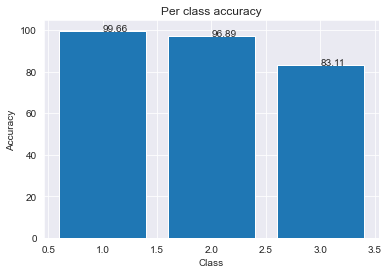

In [92]:
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
import matplotlib.pyplot as plt

y = np.round(class_accuracy,2)
x=[1,2,3]

plt.bar(x,y)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per class accuracy")
for a,b in zip(x, y): 
    plt.text(a, b, str(b))
plt.show()

Max Accuracy : 0.946423166178993
Total time taken (in Mins) =  75.6


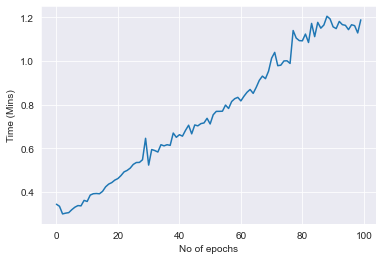

In [19]:
#Accuracy and Timetaken
print("Max Accuracy :",max(entropy_perf_hist))
%matplotlib inline
sns.set_style('darkgrid')
times_per_iteration1=[]
times_per_iteration1[:] = [x / 100000 for x in times_per_iteration]

plt.plot(range(0,100),times_per_iteration1)
plt.xlabel("No of epochs")
plt.ylabel("Time (Mins)")
print("Total time taken (in Mins) = ",round(sum(times_per_iteration1),2))

In [20]:
#saving train time and accuracy
np.save('timetaken_entropycheckboxexp4.npy',times_per_iteration1)
np.save('Accuracy_entropycheckboxexp4.npy',entropy_perf_hist)

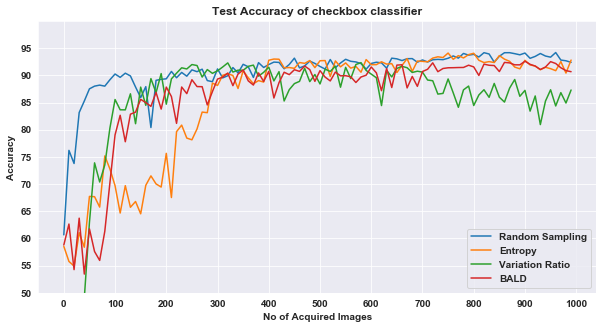

In [4]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')


plt.rcParams["font.weight"]="bold"
plt.rcParams["axes.labelweight"]="bold"

plt.figure(figsize=(10,5))
b2= np.load('./Entropy/Checkbox/Average_entropycheckbox.npy')  
b1= np.load('./RandomSampling/Checkbox/Average_randomcheckbox.npy')
b3= np.load('./VarRatio/Checkbox/Average_varratiocheckbox.npy')
b4= np.load('./BALD/Checkbox/Average_baldcheckbox.npy')
x= np.arange(0,1000,10)
y= b1[1:101]
w=np.arange(0,1000,10)
v= b2[1:101]
a=np.arange(0,1000,10)
b= b3[1:101]
c=np.arange(0,1000,10)
d= b4[1:101]

plt.plot(x,y*100,label='Random Sampling')
plt.plot(w,v*100,label='Entropy')
plt.plot(a,b*100,label='Variation Ratio')
plt.plot(c,d*100,label='BALD')


plt.xlabel('No of Acquired Images', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(50, 1*100)


plt.yticks(np.arange(50,100, 5))
plt.xticks(np.arange(0,1001, 100))
plt.title("Test Accuracy of checkbox classifier",fontweight='bold')
plt.legend()

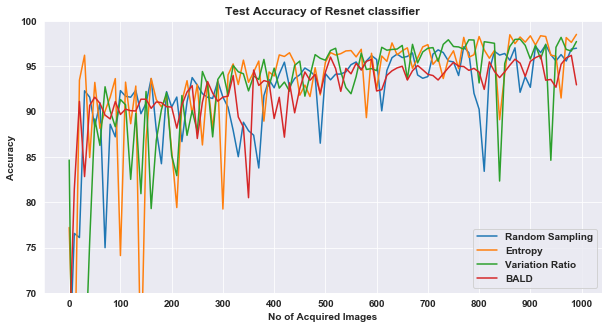

In [4]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')

plt.rcParams["font.weight"]="bold"
plt.rcParams["axes.labelweight"]="bold"

plt.figure(figsize=(10,5))
  
b2= np.load('./Entropy/Resnet/Average_entropyresnet.npy')
b1= np.load('./RandomSampling/Resnet/Average_randomresnet.npy')
b3= np.load('./VarRatio/Resnet/Average_varratioresnet.npy')
b4= np.load('./BALD/Resnet/Average_baldresnet.npy')

x= np.arange(0,1000,10)
y= b1[1:101]
w=np.arange(0,1000,10)
v= b2[1:101]

a= np.arange(0,1000,10)
b= b3[1:101]

c= np.arange(0,1000,10)
d= b4[1:101]
plt.plot(x,y*100,label='Random Sampling')

plt.plot(w,v*100,label='Entropy')
plt.plot(a,b*100,label='Variation Ratio')
plt.plot(c,d*100,label='BALD')




plt.xlabel('No of Acquired Images', fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.ylim(70, 1*100)

plt.xticks(np.arange(0,1001, 100))

plt.yticks(np.arange(70,101, 5))
plt.title("Test Accuracy of Resnet classifier", fontweight='bold')
plt.legend()